### Geomagnetic Induction in Submarine Cable during the March 1989 Geomagnetic Storm
---
* __author__ = [Chakraborty, S.; Boteler, D. B. H.]
* __copyright__ = 
* __credits__ = []
* __license__ = MIT
* __version__ = 1.0
* __maintainer__ = Chakraborty, S.
* __email__ = shibaji7@vt.edu
* __status__ = Research

>  

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(["science", "ieee"])
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma", "DejaVu Sans",
                                   "Lucida Grande", "Verdana"]
from scubas.datasets import Site, PROFILES
from scubas.models import OceanModel
from scubas.plotlib import plot_transfer_function, potential_along_section, cable_potential, update_rc_params
from scubas.cables import TransmissionLine, Cable
from scubas.conductivity import ConductivityProfile as CP

import pandas as pd
import datetime as dt
import bezpy
import numpy as np

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


Bad key "text.kerning_factor" on line 4 in
/home/shibaji/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


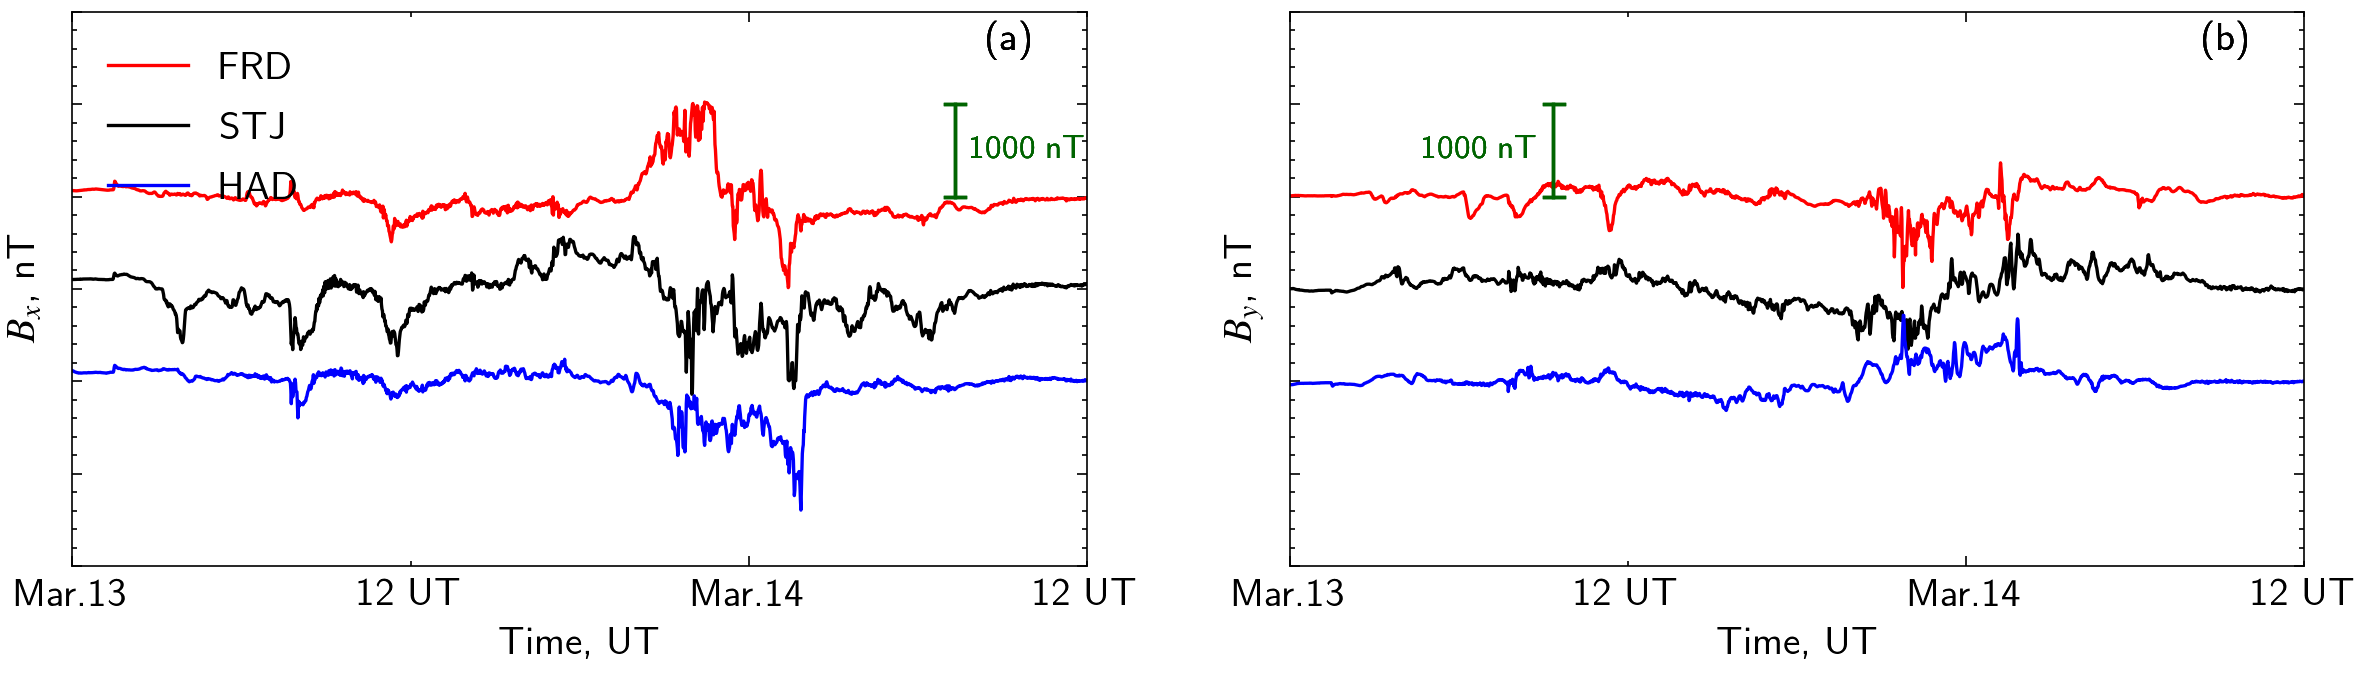

In [2]:
stns, coords = ["FRD", "STJ", "HAD"], ["XYZ", "XYZ", "HDZ"]
db="input/data/{year}/"
dates, frames = [dt.datetime(1989,3,12),dt.datetime(1989,3,13),dt.datetime(1989,3,14)], {}
for stn, coord in zip(stns, coords):
    o = pd.DataFrame()
    for d in dates:
        f = db.format(year=d.year) + "{stn}_{date}_{coord}.txt".format(stn=stn, 
                                                                       date=d.strftime("%Y%m%d"), 
                                                                       coord=coord)
        o = pd.concat([o, bezpy.mag.read_iaga(f)])
    frames[stn] = o

mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=240, figsize=(12, len(stns)))
multiplier, colors = [1, 0, -1], ["r", "k", "b"]
base=1000
for i, stn in enumerate(stns):
    frame = frames[stn]
    ax = axes[0]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    ax.plot(frame.index, (base*multiplier[i])+frame.X-np.mean(frame.X), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_x$, nT", fontdict={"color": "k"})
    ax.set_ylim(-3000,3000)
    ax.axvline(frame.index.tolist()[-1000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2000, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.axhline(1000, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[-970], 1500, "1000 nT", ha="left", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_yticklabels([])
    ax.legend(loc=2)
    ax.text(0.95,0.95,"(a)",ha="right",va="center",transform=ax.transAxes)
    ax = axes[1]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    ax.plot(frame.index, (base*multiplier[i])+frame.Y-np.mean(frame.Y), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_y$, nT", fontdict={"color": "k"})
    ax.axvline(frame.index.tolist()[2000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
    ax.axhline(1000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[1970], 1500, "1000 nT", ha="right", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_ylim(-3000,3000)
    ax.set_yticklabels([])
    ax.text(0.95,0.95,"(b)",ha="right",va="center",transform=ax.transAxes)
axes[0].set_xlabel("Time, UT")
axes[1].set_xlabel("Time, UT")
fig.subplots_adjust(wspace=.2, hspace=.1)
fig.savefig("tmp/Bxy.Field.png", bbox_inches="tight")

In [3]:
# Generate Ocean-Earth Models for 9 segments
sites = [
    PROFILES.CS_W, PROFILES.DO_1, PROFILES.DO_1, PROFILES.DO_2, PROFILES.DO_3, 
    PROFILES.DO_4, PROFILES.DO_5, PROFILES.MAR, PROFILES.DO_6, PROFILES.CS_W 
]
TFs = []
# Frequency limits
flim = [1e-6, 1e-2]
for s in sites:
    om = OceanModel(s, flim=flim)
    tf = om.get_TFs()
    TFs.append(tf)

2023-09-18 12:02:40.426 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Continental Shelf West E- and B-Fields
2023-09-18 12:02:40.442 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:40.458 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:40.474 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:40.490 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:40.506 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:40.522 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:40.537 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Mid-Atlantic Ridge E- and B-Fields
2023-09-18 12:02:40.552 | INFO     | scubas.models:__init__:44 - Compile Oce

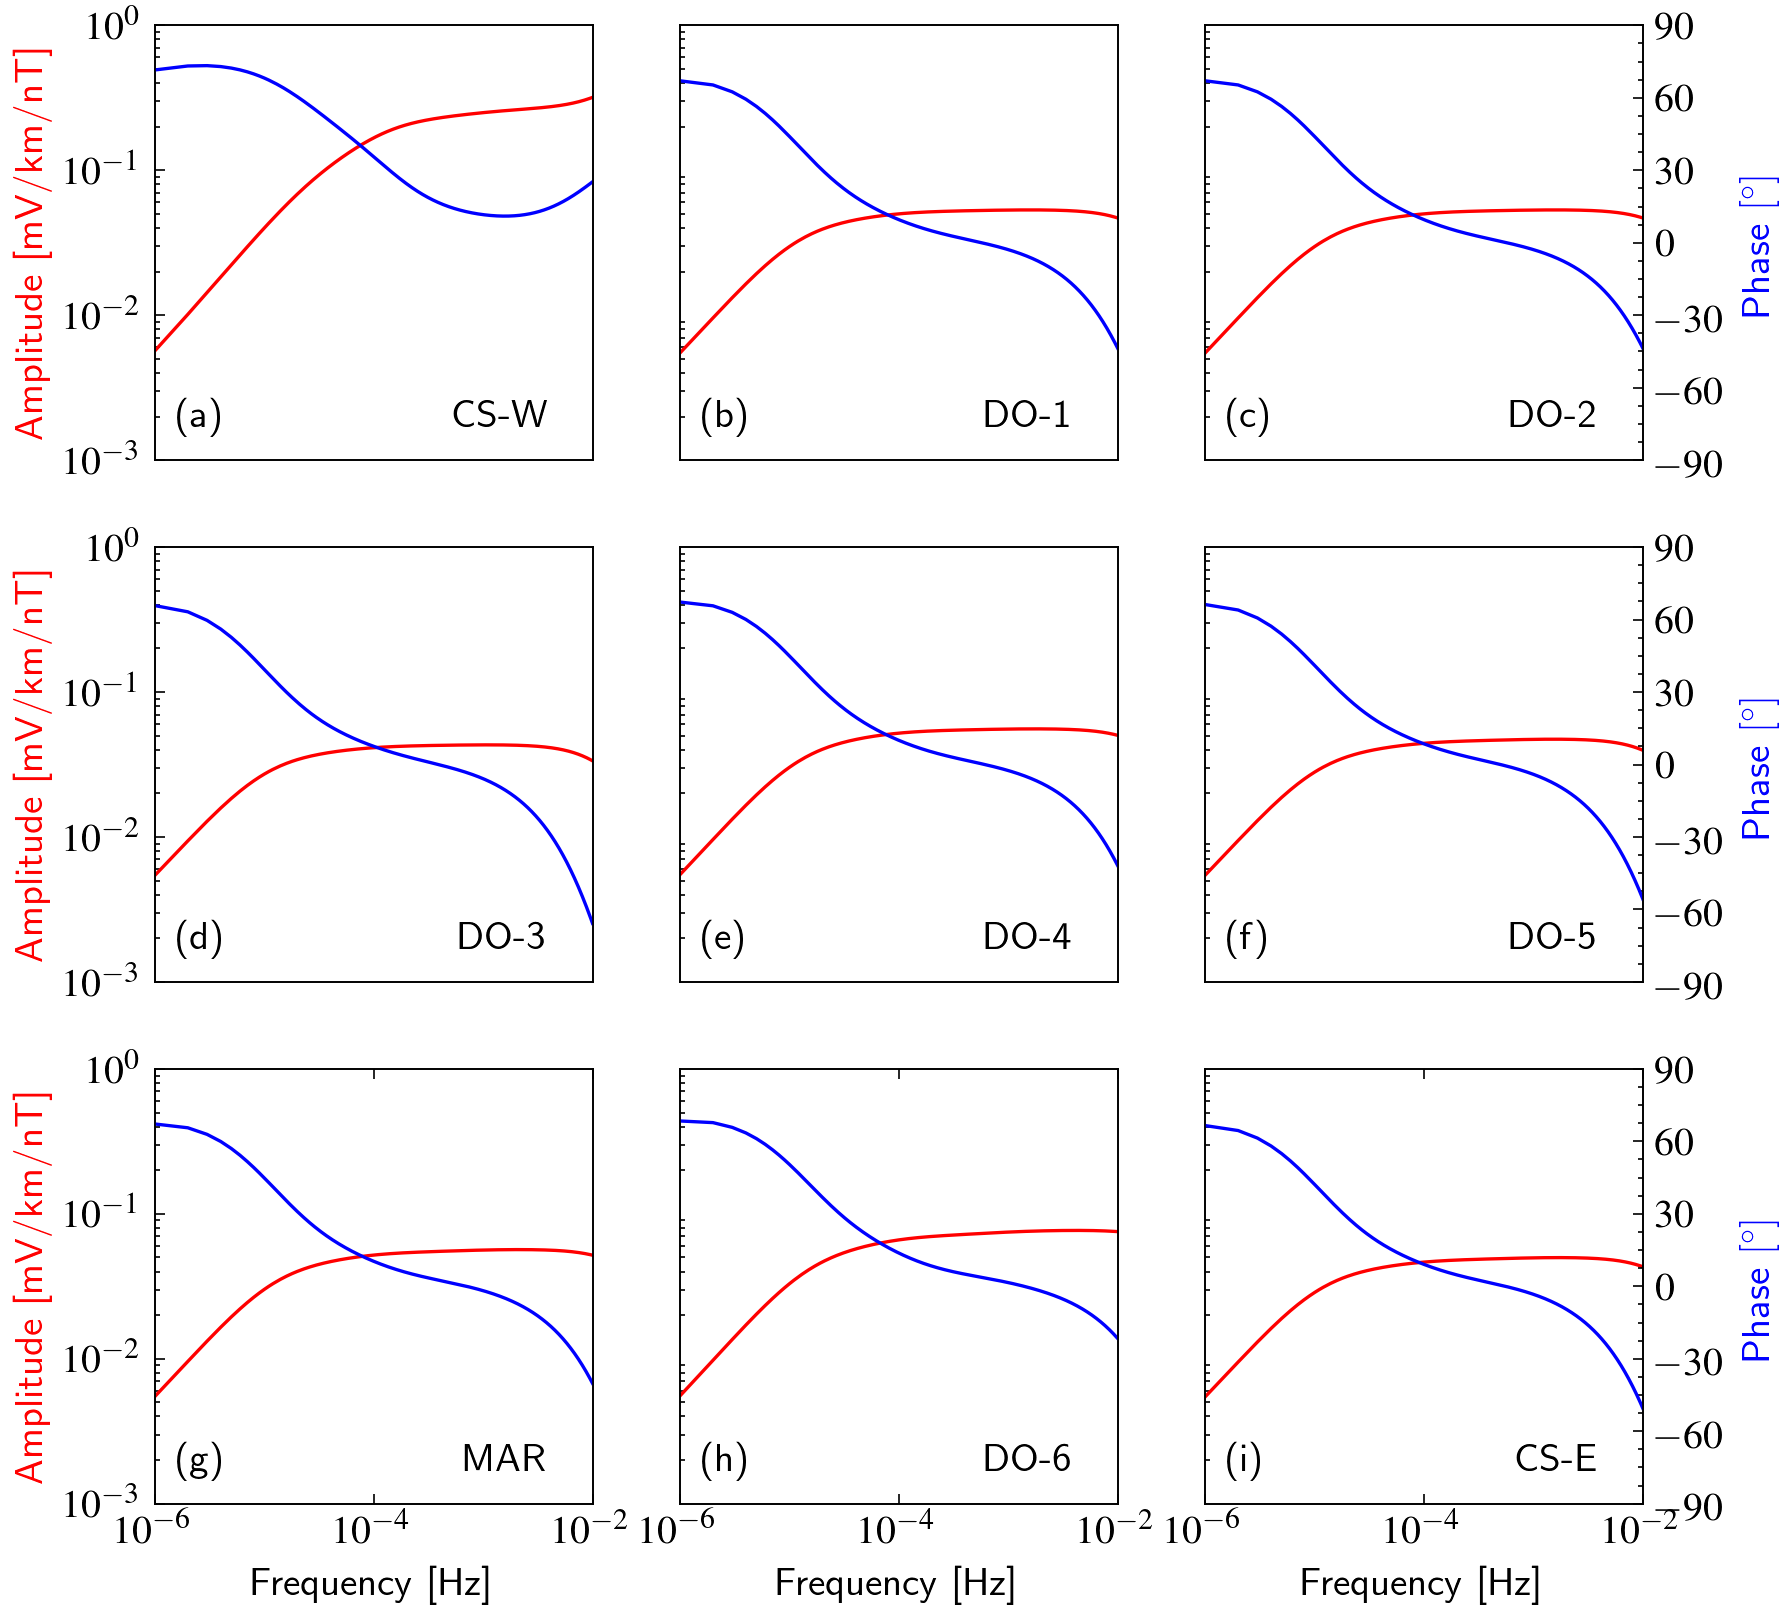

In [4]:
# Generate Ocean-Earth Models for 9 segments
segment_name = ["CS-W", "DO-1", "DO-2", "DO-3", "DO-4", "DO-5", "MAR", "DO-6", "CS-E"]

# Frequency limits
flim = [1e-6, 1e-2]


# Plot transfer function (amplitude and phase)
labs = ["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)"]
fig = plt.figure(dpi=240, figsize=(8,8))
for i in range(9):
    ax = fig.add_subplot(331+i)
    ax.loglog(TFs[i].freq, np.abs(TFs[i].E2B), "r", lw=1.0, ls="-")
    if i in [6,7,8]: ax.set_xlabel(r"Frequency [Hz]")
    else: ax.set_xticks([])
    if i in [0,3,6]: ax.set_ylabel(r"Amplitude [mV/km/nT]", color="r")
    else: ax.set_yticks([])
    ax.set_xlim(1e-6,1e-2)
    ax.set_ylim(1e-3,1e0)
    ax.text(0.9, 0.1, segment_name[i], ha="right", va="center", transform=ax.transAxes)
    ax = ax.twinx()
    ax.semilogx(TFs[i].freq, np.angle(TFs[i].E2B, deg=True), "b", lw=1., ls="-")
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    if i in [2,5,8]: ax.set_ylabel(r"Phase $[^\circ]$", color="b")
    else: ax.set_yticks([])
    if i not in [6,7,8]: ax.set_xticks([])
    ax.set_ylim(-90, 90)
    _ = ax.set_xlim(1e-6,1e-2)
    ax.text(0.05,0.1,labs[i],ha="left",va="center",transform=ax.transAxes)
fig.subplots_adjust(wspace=0.2,hspace=0.2)

In [5]:
# Simulate events
at = PROFILES.LD
# Create cable by each cable sections
tlines = []
tlines.append(
    TransmissionLine(
        sec_id="CS-W",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=39.6, lon=-74.33), 
                final=dict(lat=38.79, lon=-72.62)
            )
        ),
        elec_params=dict(
            site=PROFILES.CS_W,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=None,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/FRD_19890312_XYZ.txt",
        "input/data/1989/FRD_19890313_XYZ.txt",
        "input/data/1989/FRD_19890314_XYZ.txt",
    ]),
)
tlines.append(
    TransmissionLine(
        sec_id="DO-1",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=38.79, lon=-72.62), 
                final=dict(lat=37.11, lon=-68.94)
            )
        ),
        elec_params=dict(
            site=PROFILES.DO_1,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=None,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/FRD_19890312_XYZ.txt",
        "input/data/1989/FRD_19890313_XYZ.txt",
        "input/data/1989/FRD_19890314_XYZ.txt",
    ])
)
tlines.append(
    TransmissionLine(
        sec_id="DO-2",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=37.11, lon=-68.94), 
                final=dict(lat=39.80, lon=-48.20)
            )
        ),
        elec_params=dict(
            site=PROFILES.DO_2,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=None,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/STJ_19890312_XYZ.txt",
        "input/data/1989/STJ_19890313_XYZ.txt",
        "input/data/1989/STJ_19890314_XYZ.txt",
    ])
)
tlines.append(
    TransmissionLine(
        sec_id="DO-3",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=39.80, lon=-48.20), 
                final=dict(lat=40.81, lon=-45.19)
            )
        ),
        elec_params=dict(
            site=PROFILES.DO_3,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=None,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/STJ_19890312_XYZ.txt",
        "input/data/1989/STJ_19890313_XYZ.txt",
        "input/data/1989/STJ_19890314_XYZ.txt",
    ])
)
tlines.append(
    TransmissionLine(
        sec_id="DO-4",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=40.81, lon=-45.19), 
                final=dict(lat=43.15, lon=-39.16)
            )
        ),
        elec_params=dict(
            site=PROFILES.DO_4,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=None,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/STJ_19890312_XYZ.txt",
        "input/data/1989/STJ_19890313_XYZ.txt",
        "input/data/1989/STJ_19890314_XYZ.txt",
    ])
)
tlines.append(
    TransmissionLine(
        sec_id="DO-5",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=43.15, lon=-39.16), 
                final=dict(lat=44.83, lon=-34.48)
            )
        ),
        elec_params=dict(
            site=PROFILES.DO_5,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=None,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/STJ_19890312_XYZ.txt",
        "input/data/1989/STJ_19890313_XYZ.txt",
        "input/data/1989/STJ_19890314_XYZ.txt",
    ])
)
tlines.append(
    TransmissionLine(
        sec_id="MAR",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=44.83, lon=-34.48), 
                final=dict(lat=46.51, lon=-22.43)
            )
        ),
        elec_params=dict(
            site=PROFILES.MAR,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=None,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/STJ_19890312_XYZ.txt",
        "input/data/1989/STJ_19890313_XYZ.txt",
        "input/data/1989/STJ_19890314_XYZ.txt",
    ])
)
tlines.append(
    TransmissionLine(
        sec_id="DO-6",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=46.51, lon=-22.43), 
                final=dict(lat=47.85, lon=-9.05)
            )
        ),
        elec_params=dict(
            site=PROFILES.DO_6,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=None,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/HAD_19890312_HDZ.txt",
        "input/data/1989/HAD_19890313_HDZ.txt",
        "input/data/1989/HAD_19890314_HDZ.txt",
    ])
)
tlines.append(
    TransmissionLine(
        sec_id="CS-E",
        directed_length=dict(
            edge_locations=dict(
                initial=dict(lat=47.85, lon=-9.05), 
                final=dict(lat=50.79, lon=-4.55)
            )
        ),
        elec_params=dict(
            site=PROFILES.CS_E,
            width=1.0,
            flim=[1e-6, 1e0],
        ),
        active_termination=dict(
            right=at,
            left=None,
        ),
    ).compile_oml([
        "input/data/1989/HAD_19890312_HDZ.txt",
        "input/data/1989/HAD_19890313_HDZ.txt",
        "input/data/1989/HAD_19890314_HDZ.txt",
    ])
)

2023-09-18 12:02:43.162 | INFO     | scubas.cables:calc_trasmission_line_parameters:214 - Cable width CS-W: 1.0
2023-09-18 12:02:43.163 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Continental Shelf West E- and B-Fields
2023-09-18 12:02:43.250 | INFO     | scubas.cables:calc_trasmission_line_parameters:214 - Cable width DO-1: 1.0
2023-09-18 12:02:43.250 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:43.400 | INFO     | scubas.cables:calc_trasmission_line_parameters:214 - Cable width DO-2: 1.0
2023-09-18 12:02:43.400 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:43.486 | INFO     | scubas.cables:calc_trasmission_line_parameters:214 - Cable width DO-3: 1.0
2023-09-18 12:02:43.486 | INFO     | scubas.models:__init__:44 - Compile Ocean-model: Deep Ocean E- and B-Fields
2023-09-18 12:02:43.569 | INFO     | scubas.cables:calc_trasmission_line_parameters:214 

In [6]:
cable = Cable(tlines, tlines[0].components)
# cable.tot_params.head()

2023-09-18 12:02:44.007 | INFO     | scubas.cables:run_nodal_analysis:350 - Eq. nodal analysis.
2023-09-18 12:02:44.008 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:0
2023-09-18 12:02:44.009 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:1
2023-09-18 12:02:44.009 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:2
2023-09-18 12:02:44.010 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:3
2023-09-18 12:02:44.010 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:4
2023-09-18 12:02:44.011 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:5
2023-09-18 12:02:44.011 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:6
2023-09-18 12:02:44.012 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:7
2023-09-18 12:02:44.012 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:8
2023-09-18 12:02:44.013 | INFO     | scubas.cables:run_nodal_analysis:354 - Node:9
2023-09-18 12:02:44.013 | INFO     | scubas.cables:run_nodal_analysis:382 

2023-09-18 12:02:44.129 | INFO     | scubas.cables:_pot_alongCS_:279 - Pot along cable section at: 0


{'figure': <Figure size 900x450 with 1 Axes>,
 'axes': <matplotlib.axes._subplots.AxesSubplot at 0x7f3d536b9410>}

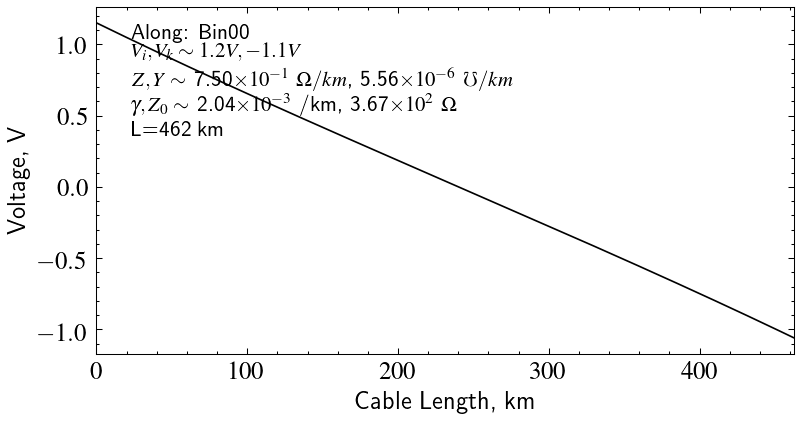

In [7]:
tl = tlines[-1]
V, x = tl._pot_alongCS_(idx=0)
potential_along_section(V, x, 0, tl.end_pot.Vi[0], tl.end_pot.Vk[0], tl.Z, tl.Y, tl.gma, tl.Z0)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


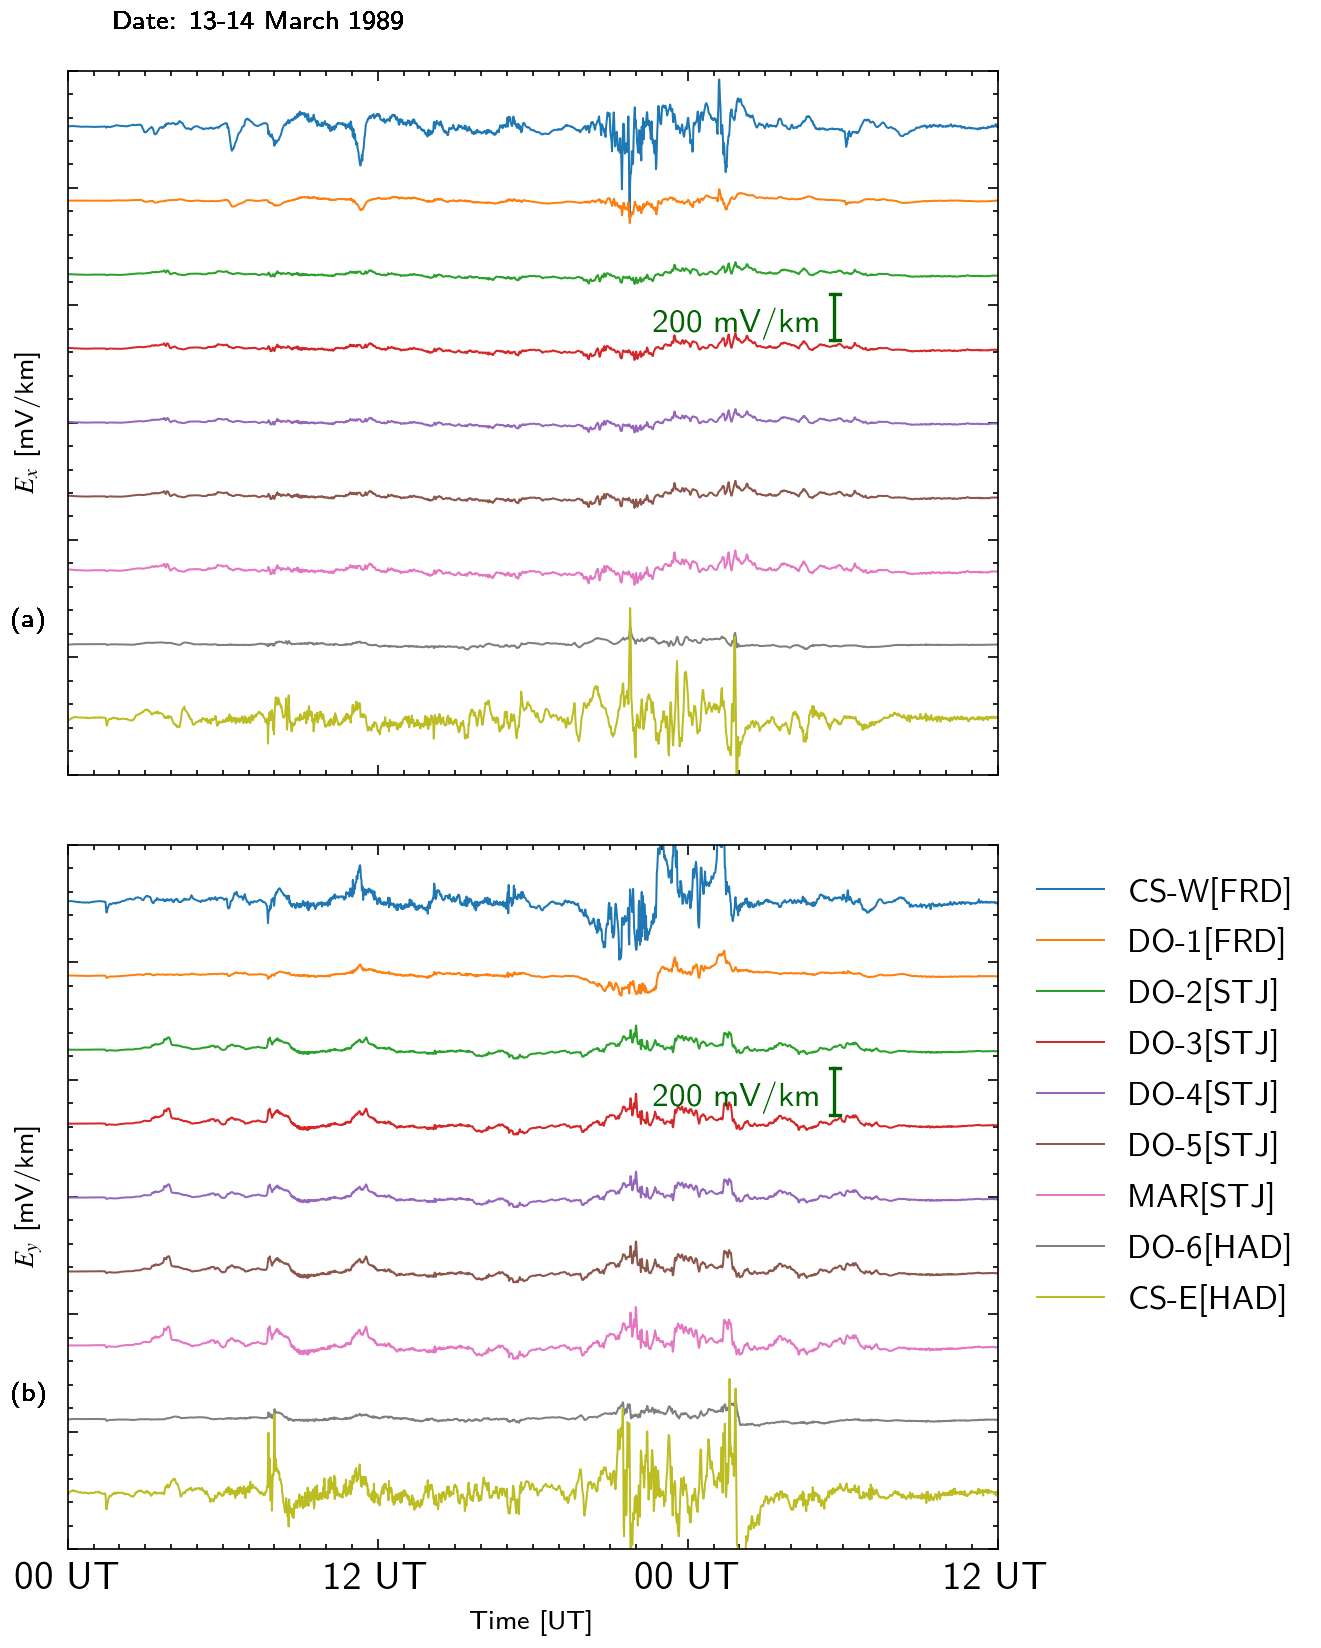

In [8]:
params = cable.tot_params
segment_name = ["CS-W", "DO-1", "DO-2", "DO-3", "DO-4", "DO-5", "MAR", "DO-6", "CS-E"]
stations = ["FRD", "FRD", "STJ", "STJ", "STJ", "STJ", "STJ", "HAD", "HAD"]

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(["science", "ieee"])
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma", "DejaVu Sans",
                                   "Lucida Grande", "Verdana"]

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, axes = plt.subplots(nrows=2, ncols=1, dpi=240, figsize=(5, 8), sharex=True)
multiplier, colors = np.array([4,3,2,1,0,-1,-2,-3,-4])*3.5, ["r", "k", "b"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
base=90
for i in range(9):
    ax = axes[0]
    ax.text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    #ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    ax.plot(
        params.index, 
        (base*multiplier[i])+params["E.X.%02d"%(i)]-np.mean(params["E.X.%02d"%(i)]), 
        colors[i], 
        ls="-", 
        lw=0.6
    )
    ax.set_xticklabels([])
    ax.set_ylabel(r"$E_x$ [mV/km]", fontdict={"color": "k"})
    ax.set_ylim(-1500,1500)
    ax.text(-0.06,0.2,"(a)",ha="left",va="bottom",transform=ax.transAxes)
    if i==0:
        ax.axvline(params.index.tolist()[-1100], ymin=18.5/30, ymax=20.5/30, 
                   color = "darkgreen", drawstyle="steps-mid")
        ax.axhline(350, xmin=0.82, xmax=0.82+1e-2, color = "darkgreen")
        ax.axhline(550, xmin=0.82, xmax=0.82+1e-2, color = "darkgreen")
        ax.text(params.index.tolist()[2800], 425, "200 mV/km", ha="left", va="center", 
                fontdict={"color": "darkgreen", "size":10})
    ax.set_yticklabels([])
    ax.legend(loc=2)
    ax = axes[1]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    #ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    txt = r"%s[%s]"%(segment_name[i], stations[i])
    ax.plot(
        params.index, 
        (base*multiplier[i])+params["E.Y.%02d"%(i)]-np.mean(params["E.Y.%02d"%(i)]), 
        colors[i], 
        ls="-", 
        lw=0.6, 
        label=txt
    )
    ax.set_ylabel(r"$E_y$ [mV/km]", fontdict={"color": "k"})
    if i==0:
        ax.axvline(params.index.tolist()[-1100], ymin=18.5/30, ymax=20.5/30, 
                   color = "darkgreen", drawstyle="steps-mid")
        ax.axhline(350, xmin=0.82, xmax=0.82+1e-2, color = "darkgreen")
        ax.axhline(550, xmin=0.82, xmax=0.82+1e-2, color = "darkgreen")
        ax.text(params.index.tolist()[2800], 425, "200 mV/km", ha="left", va="center", 
                fontdict={"color": "darkgreen", "size":10})
        #ax.axvline(frame.index.tolist()[2000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
        #ax.axhline(2000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
        #ax.axhline(1000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
        #ax.text(frame.index.tolist()[1970], 1500, "1000 nT", ha="right", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_ylim(-1500,1500)
    ax.set_yticklabels([])
    ax.text(-0.06,0.2,"(b)",ha="left",va="bottom",transform=ax.transAxes)
axes[1].set_xlabel("Time [UT]")
axes[1].legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=10)
fig.subplots_adjust(wspace=.1, hspace=.1)

Text(1989-03-13 15:50:00, 2300, '500 V')

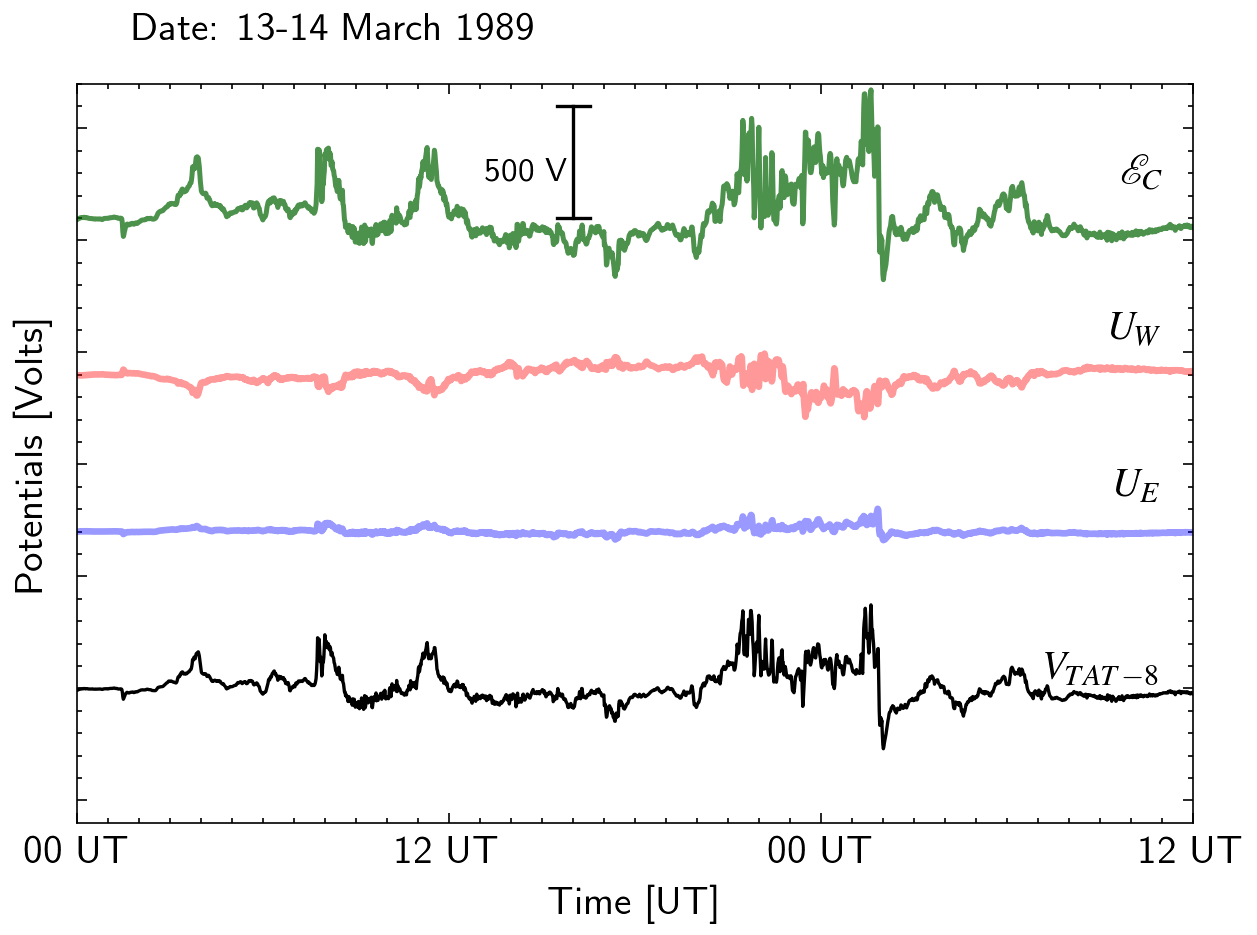

In [9]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=240, figsize=(6, 4), sharex=True)
ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.plot(params.index, params["V(v)"]+2100, "darkgreen", ls="-", lw=1.5, label=r"$\mathcal{E}_C$", alpha=0.7)
ax.plot(params.index, params["U0"]+1400, "r", ls="-", lw=2, alpha=0.4, label=r"$U_W$")
ax.plot(params.index, params["U1"]+700, "b", ls="-", lw=2, alpha=0.4, label=r"$U_E$")
ax.plot(params.index, params["V(v)"]+(params["U0"]-params["U1"]), "k", ls="-", lw=1., label=r"$V_{TAT-8}$")
ax.set_ylim(-600, 2700)
ax.set_xlabel("Time [UT]")
ax.set_ylabel("Potentials [Volts]")
ax.text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=ax.transAxes)
#ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
ax.set_yticklabels([])
ax.text(dt.datetime(1989,3,14,11), params["U0"].iloc[-1]+1500, r"$U_W$", ha="right", va="bottom")
ax.text(dt.datetime(1989,3,14,11), params["U1"].iloc[-1]+800, r"$U_E$", ha="right", va="bottom")
ax.text(dt.datetime(1989,3,14,11), params["V(v)"].iloc[-1]+2200, r"$\mathcal{E}_C$", ha="right", va="bottom")
ax.text(dt.datetime(1989,3,14,11), (params["V(v)"]+(params["U0"]-params["U1"])).iloc[-1], r"$V_{TAT-8}$", 
        ha="right", va="bottom")
ax.axvline(dt.datetime(1989,3,13,16), ymin=2700/3300, ymax=3200/3300, color = "k", drawstyle="steps-mid")
ax.axhline(2700-600, xmin=0.43, xmax=0.43+3e-2, color = "k")
ax.axhline(3200-600, xmin=0.43, xmax=0.43+3e-2, color = "k")
ax.text(dt.datetime(1989,3,13,15,50), 2300, "500 V", ha="right", va="center", fontdict={"color": "k", "size":10})

Text(0.05, 1.05, 'Date: 13-14 March 1989')

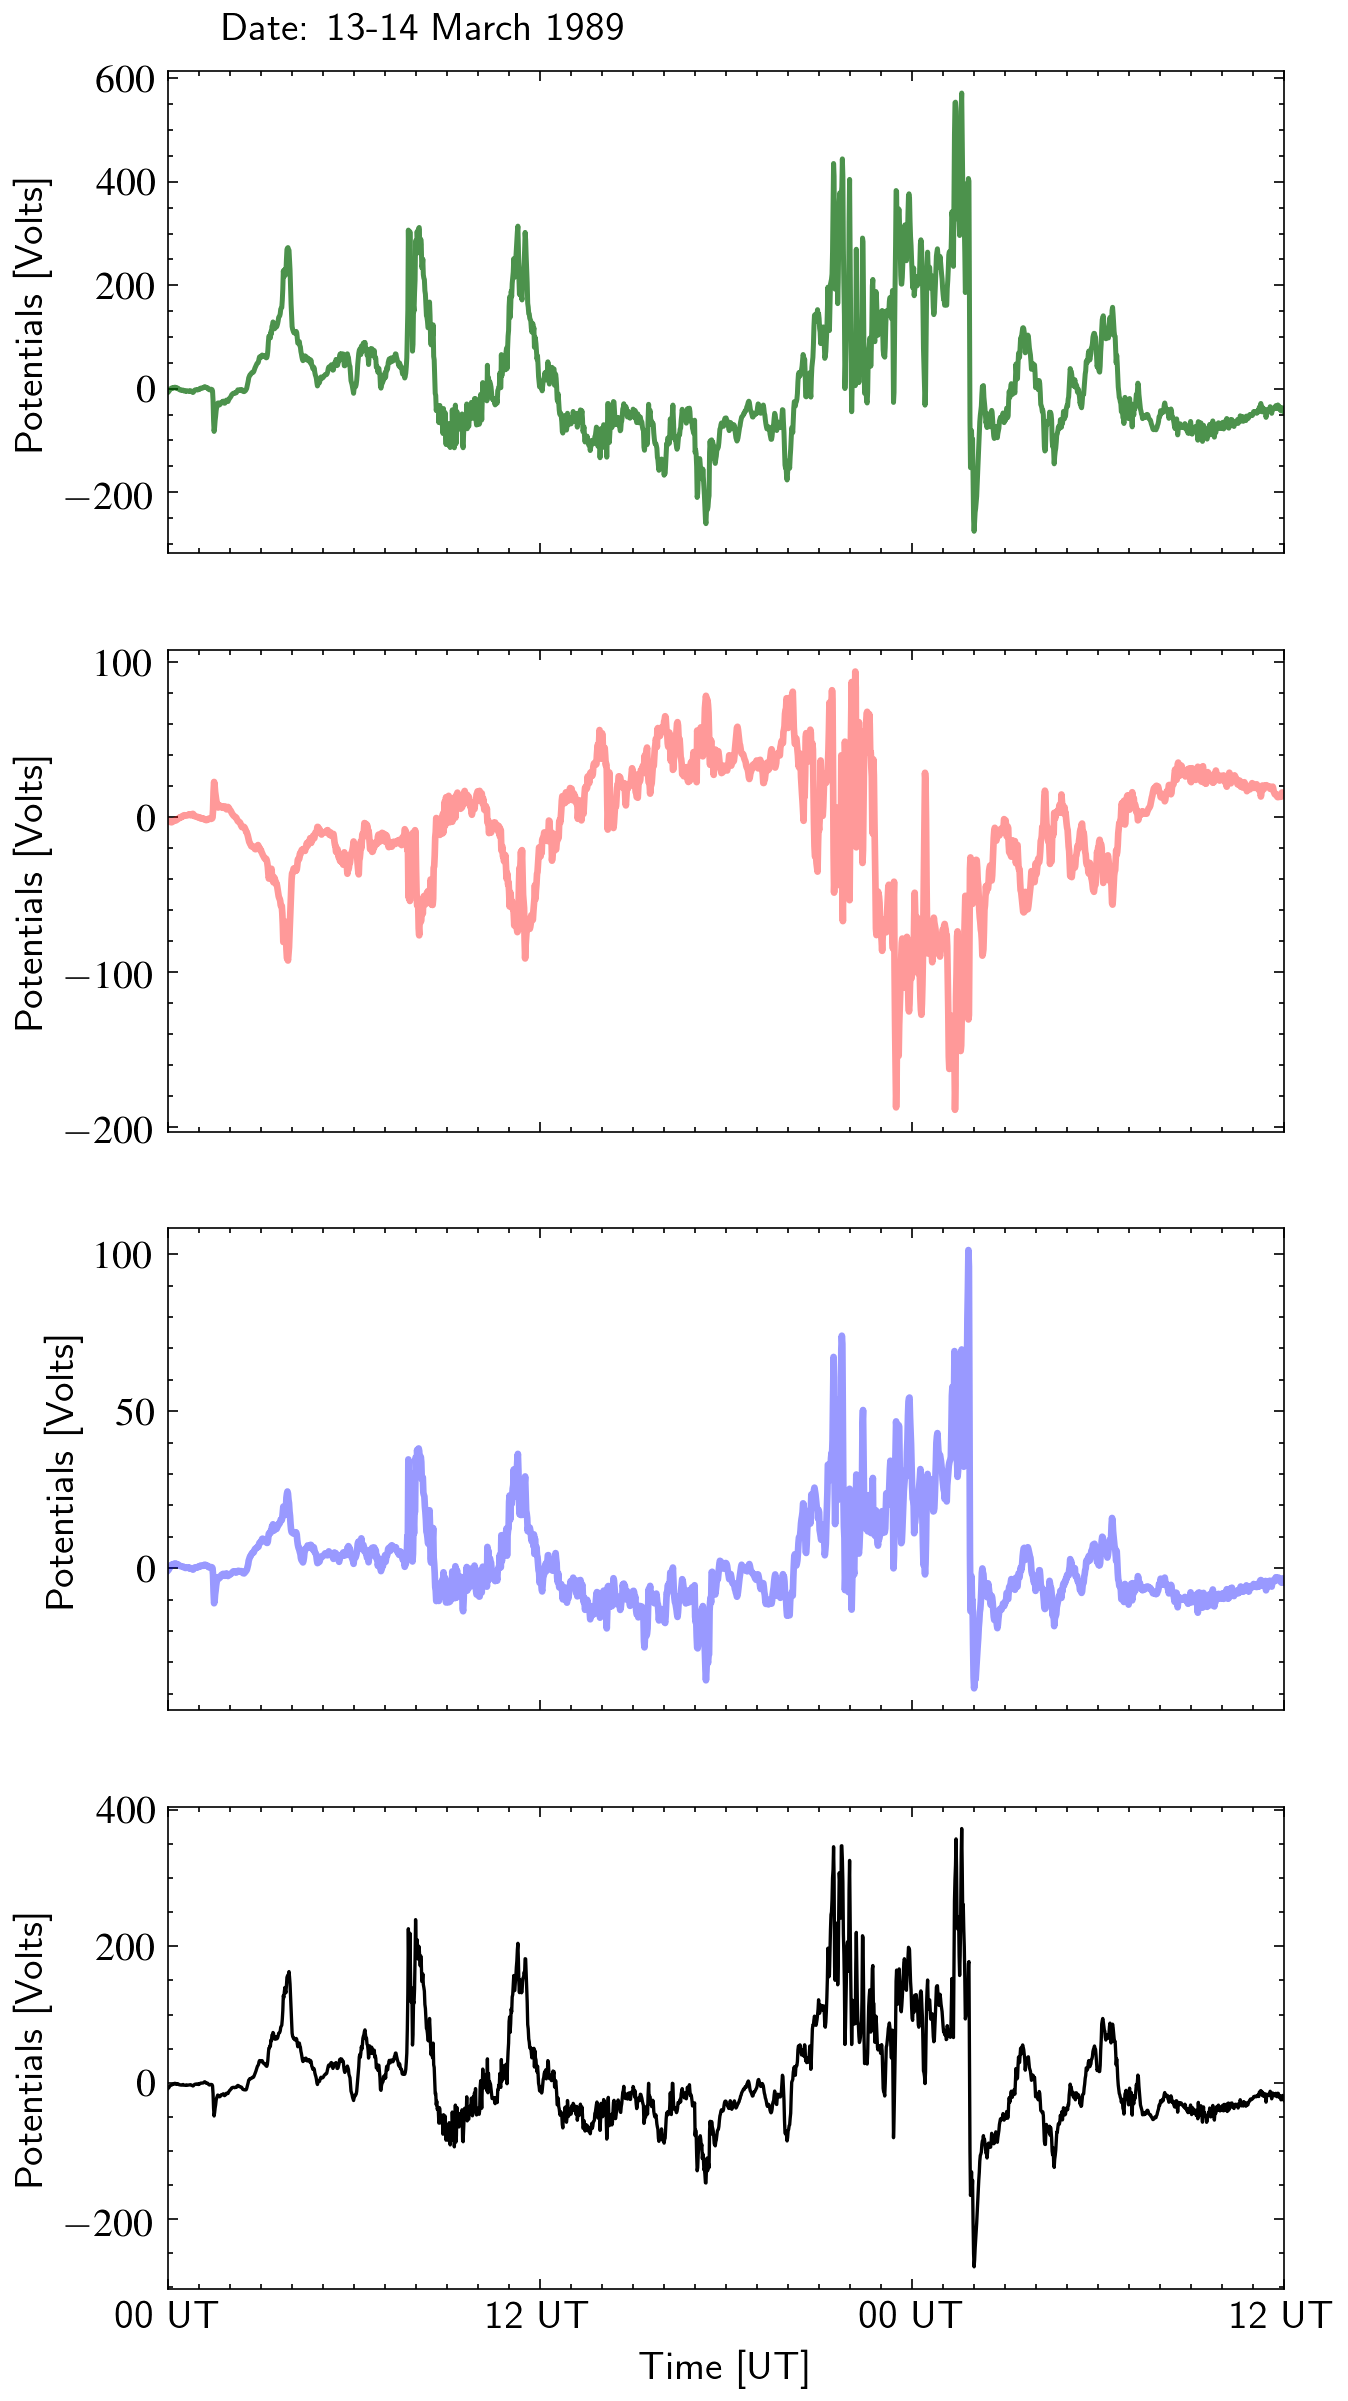

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=1, dpi=240, figsize=(6, 12), sharex=True)
for ax in axes:
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    ax.set_ylabel("Potentials [Volts]")
axes[0].plot(params.index, params["V(v)"], "darkgreen", ls="-", lw=1.5, label=r"$\mathcal{E}_C$", alpha=0.7)
axes[1].plot(params.index, params["U0"], "r", ls="-", lw=2, alpha=0.4, label=r"$U_W$")
axes[2].plot(params.index, params["U1"], "b", ls="-", lw=2, alpha=0.4, label=r"$U_E$")
axes[3].plot(params.index, params["V(v)"]+(params["U0"]-params["U1"]), "k", ls="-", lw=1., label=r"$V_{TAT-8}$")
axes[3].set_xlabel("Time [UT]")
axes[0].text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=axes[0].transAxes)
#ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
